In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.callbacks import Callback
import pandas as pd
import pickle

In [2]:
file_path = 'D:/bla bla/exported_dataset_New.xlsx'
df = pd.read_excel(file_path)

In [3]:
# Prepare features (X) and labels (Y)
X = df.drop(['Max Rising Slope', 'Soak Time', 'Reflow Time', 'Peak Temp'], axis=1)  # Drop target columns from features
Y = df[['Reflow Time']]  # Multi-output labels

In [4]:
# Initialize MinMaxScaler
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

# Scale the features and labels
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

In [5]:
with open('scaler_Y.pkl', 'wb') as f:
    pickle.dump(scaler_Y, f)

In [5]:
# Split the dataset into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.1, random_state=42)

In [6]:
# Define the custom callback to track R² score
class R2ScoreCallback(Callback):
    def __init__(self, X_val, Y_val):
        self.X_val = X_val
        self.Y_val = Y_val
        self.r2_scores = []

    def on_epoch_end(self, epoch, logs=None):
        predictions = self.model.predict(self.X_val)  # Predict on validation set
        predictions = scaler_Y.inverse_transform(predictions)  # Inverse transform predictions
        Y_val_original = scaler_Y.inverse_transform(self.Y_val)  # Inverse transform actual values
        r2 = r2_score(Y_val_original, predictions)  # Calculate R² score
        self.r2_scores.append(r2)  # Save R² score
        print(f"Epoch {epoch+1}: R² score = {r2}")

In [7]:
# Instantiate the R² score callback
r2_callback = R2ScoreCallback(X_test, Y_test)

In [8]:
model = Sequential()

# Layer 0: 864 units, ReLU activation, 0.2 dropout
model.add(Dense(864, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))

# Layer 1: 256 units, Tanh activation, 0.4 dropout
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.4))

# Layer 2: 736 units, ReLU activation, 0.4 dropout
model.add(Dense(736, activation='relu'))
model.add(Dropout(0.4))

# Output layer for regression (1 output unit)
model.add(Dense(1))

In [9]:
# Compile the model with Adam optimizer and the provided learning rate
optimizer = Adam(learning_rate=0.003813467045494337)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [10]:
# Train the model and track history and R² score
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test),callbacks=[r2_callback])

Epoch 1/50

1/1 [==============================] - 0s 100ms/steps: 0.984
Epoch 1: R² score = -2.4934773864648005
9/9 [==============================] - 3s 73ms/step - loss: 0.6915 - val_loss: 0.1576
Epoch 2/50
1/1 [==============================] - 0s 23ms/stepss: 0.04
Epoch 2: R² score = -0.2974592476319393
9/9 [==============================] - 0s 21ms/step - loss: 0.0436 - val_loss: 0.0585
Epoch 3/50
1/1 [==============================] - 0s 16ms/stepss: 0.02
Epoch 3: R² score = 0.64445014342011
9/9 [==============================] - 0s 22ms/step - loss: 0.0284 - val_loss: 0.0160
Epoch 4/50
1/1 [==============================] - 0s 16ms/stepss: 0.01
Epoch 4: R² score = 0.5000758006180094
9/9 [==============================] - 0s 22ms/step - loss: 0.0195 - val_loss: 0.0226
Epoch 5/50
1/1 [==============================] - 0s 31ms/stepss: 0.01
Epoch 5: R² score = 0.6442396132148815
9/9 [==============================] - 0s 25ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 6/50
1/1 [==

In [11]:
# Make predictions on the test set
predictions_scaled = model.predict(X_test)

1/1 [==============================] - 0s 33ms/step


In [12]:
# Inverse transform the predictions and actual values to get them back to the original scale
predictions = scaler_Y.inverse_transform(predictions_scaled)
Y_test_original = scaler_Y.inverse_transform(Y_test)

In [13]:
# Print a few predictions and actual values in their original (unscaled) form
for i in range(20):
    print(f"Predicted: {predictions[i]}, Actual: {Y_test_original[i]}")

Predicted: [47.00412], Actual: [42.74]
Predicted: [46.985455], Actual: [49.74]
Predicted: [69.214355], Actual: [66.44]
Predicted: [45.232777], Actual: [37.65]
Predicted: [76.25226], Actual: [83.88]
Predicted: [47.126774], Actual: [49.01]
Predicted: [45.305286], Actual: [42.98]
Predicted: [46.23639], Actual: [52.91]
Predicted: [44.275303], Actual: [42.9]
Predicted: [44.841675], Actual: [38.05]
Predicted: [48.94505], Actual: [51.61]
Predicted: [43.810555], Actual: [45.15]
Predicted: [48.093147], Actual: [57.17]
Predicted: [46.377396], Actual: [41.71]
Predicted: [45.366642], Actual: [38.97]
Predicted: [43.845192], Actual: [43.66]
Predicted: [46.075333], Actual: [42.74]
Predicted: [43.15806], Actual: [40.3]
Predicted: [47.12722], Actual: [45.16]
Predicted: [45.152184], Actual: [54.27]


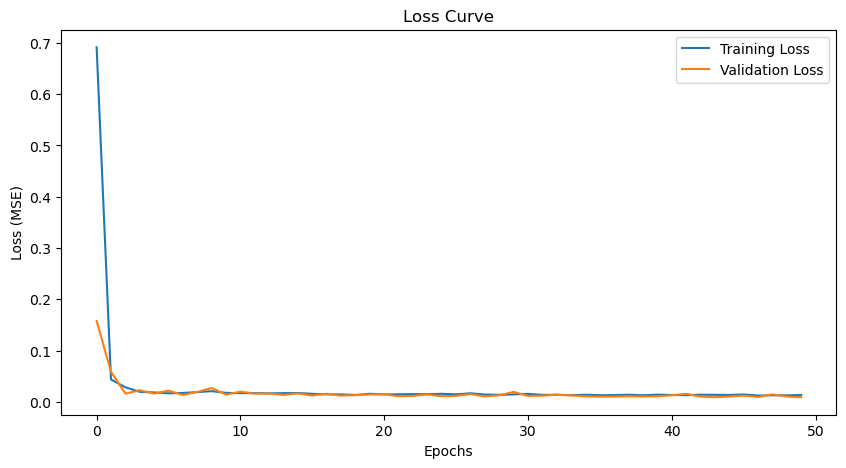

In [14]:
# Plot the loss curve (training and validation)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

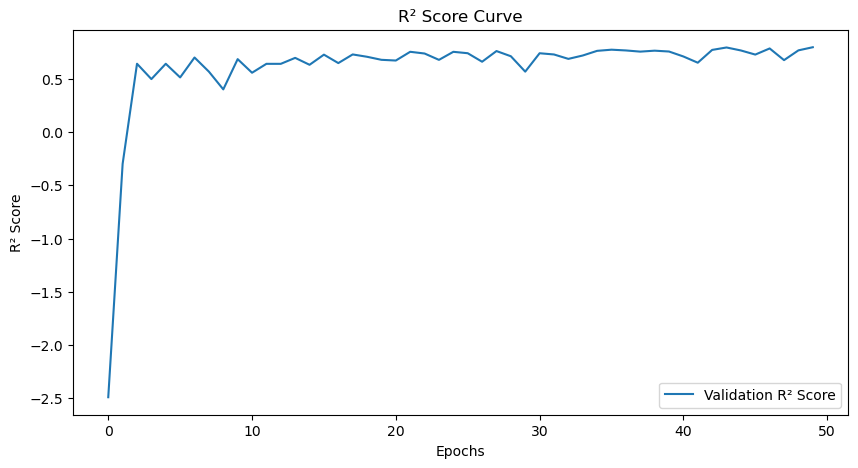

In [15]:
# Plot the R² score curve for validation set
plt.figure(figsize=(10, 5))
plt.plot(r2_callback.r2_scores, label='Validation R² Score')
plt.title('R² Score Curve')
plt.xlabel('Epochs')
plt.ylabel('R² Score')
plt.legend()
plt.show()

In [16]:
# Save the trained model to a file
model_save_path = 'D:/aaaaaa/Reflow_Time_2.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to D:/aaaaaa/Reflow_Time_2.h5


d:\Installation\Anacondaa\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
